In [ ]:
%tensorflow_version 2.x

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import sys
import os
sys.path.append('/content/gdrive/My Drive/W266-NLP/Project')
os.chdir('/content/gdrive/My Drive/W266-NLP/Project')
os.listdir()

In [1]:
import os
import time
import numpy as np
import pickle
import pandas as pd
import json
from pandas.io.json import json_normalize
from collections import Counter
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
import nltk
from functools import reduce
!pip install wget
# Load PyDrive and Google Auth related packages
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from functools import reduce
flatten = lambda data: reduce(lambda x, y: x + y, data)
import glove_helper
!pip install tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Load the json data
def load_json_file(name):
  """
  Load the json file and return a json object
  """
  with open(name,encoding='utf-8') as myfile:
    data = json.load(myfile)
    return data

# Convert json data object to a pandas data frame
def convert_to_pd(data):
  """
  Load the data to a pandas dataframe.
  Dataframe Columns:
    title
    para_index
    context
    q_index
    q_id
    q_isimpossible
    q_question
    q_anscount - number of answers
    q_answers - a list of object e.g [{ text: '', answer_start: 123}, ...]
  """
  result = []
  for pdata in data['data']:
    for para in pdata['paragraphs']:
      for q in para['qas']:
        result.append({
            'title' : pdata['title'],
            'context' : para['context'],
            'q_id' : q['id'],
            'q_isimpossible' : q['is_impossible'],
            'q_question' : q['question'],
            'q_anscount' : len(q['answers']),
            'q_answers' : [a for a in q['answers']],
            'q_answers_text': [a.get("text") for a in q['answers']],
            'context_lowercase': para['context'].lower(),
            'q_question_lowercase' : q['question'].lower(),
            'q_answers_text_lowercase': [a.get("text").lower() for a in q['answers']],
            
        })

  return pd.DataFrame.from_dict(result, orient='columns')

# Load the file from shareable google drive link and return a pandas dataframe
def loadDataFile(filename): 
  """
  Download a file from google drive with the shared link
  """ 
  data = load_json_file(filename)
  return convert_to_pd(data)

In [2]:
# DONOT RUN THIS ON COLAB#
#to make use of CPU and not GPU DONOT RUN THIS ON COLAB
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [3]:
train_filename = 'train-v2.0.json'
dev_filename = 'dev-v2.0.json'

train_pd = loadDataFile(train_filename)
dev_pd = loadDataFile(dev_filename)

In [4]:
def get_c_q_a(dataset):
    q_id_list = []
    context_list =[]
    questions_list = []
    answers_list =[]
    q_impossible_list =[]
    for index,row in dataset.iterrows():
        q_id_list.append(row.q_id)
        context_list.append(row.context)
        questions_list.append(row.q_question)
        q_impossible_list.append(int(row.q_isimpossible))
        if len(row.q_answers_text)>0 :
            answers_list.append(row.q_answers_text[0])
        else:
            answers_list.append("")
    return [q_id_list,context_list,questions_list,q_impossible_list,answers_list]

train_lists = get_c_q_a(train_pd)
dev_lists = get_c_q_a(dev_pd)
context_maxlen = max(map(len, (x.split() for x in train_lists[1])))
question_maxlen = max(map(len, (x.split() for x in train_lists[2])))
answer_maxlen = max(map(len, (x.split() for x in train_lists[4])))
print("Max context length:",context_maxlen)
print("Max question length:",question_maxlen)
print("Max answer length:",answer_maxlen)

Max context length: 653
Max question length: 40
Max answer length: 43


In [5]:
context_maxlen = 214
question_maxlen = 18
answer_maxlen = 10
ndim = 300

In [6]:
def tokenize_c_q_a(dataset,num_words=None):
    tokenizer = Tokenizer(num_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"''",oov_token='<unk>')
    data = dataset[1]+dataset[2]+dataset[4]
    tokenizer.fit_on_texts(data)
    vocab = {}
    for word,i in tokenizer.word_index.items():
        if num_words is not None:
          if i <= num_words:
            vocab[word] = i
        else:
          vocab[word] = i
    #vocab = tokenizer.word_index
    vocab['<s>'] = len(vocab)+1
    vocab['</s>'] = len(vocab)+1
    id_vocab = {value: key for key, value in vocab.items()}
    return (tokenizer,vocab,id_vocab)

tokenizer_obj,vocab,id_vocab = tokenize_c_q_a(train_lists,num_words=5000)

vocab_size = len(vocab)
print("Vocab Size:",vocab_size)

def vectorize_data(tokenizer_obj,train_lists):
    context_seq = tokenizer_obj.texts_to_sequences(train_lists[1])
    question_seq = tokenizer_obj.texts_to_sequences(train_lists[2])
    answer_seq = tokenizer_obj.texts_to_sequences(train_lists[4])
    answer_input_seq = [[vocab['<s>']]+i+[vocab['</s>']] for i in answer_seq]
    answer_target_seq = [i+[vocab['</s>']] for i in answer_seq]
    context_seq_padded = pad_sequences(context_seq,context_maxlen,padding='post', truncating='post')
    question_seq_padded = pad_sequences(question_seq,question_maxlen,padding='post', truncating='post')
    answer_seq_padded = pad_sequences(answer_seq,answer_maxlen,padding='post', truncating='post')
    answer_input_seq_padded = pad_sequences(answer_input_seq,answer_maxlen+2,padding='post', truncating='post')
    answer_target_seq_padded = pad_sequences(answer_target_seq,answer_maxlen+2,padding='post', truncating='post')
    answer_impossible = np.array(train_lists[3])
    indices = np.arange(context_seq_padded.shape[0])
    np.random.seed(19)
    np.random.shuffle(indices)
    context_seq_padded = context_seq_padded[indices]
    question_seq_padded = question_seq_padded[indices]
    answer_seq_padded = answer_seq_padded[indices]
    answer_input_seq_padded = answer_input_seq_padded[indices]
    answer_target_seq_padded = answer_target_seq_padded[indices]
    answer_impossible_shuffled = answer_impossible[indices]
    train_samples = int(((context_seq_padded.shape[0]*.8)//128)*128)
    end_samples = int((context_seq_padded.shape[0]//128)*128)
    train_context_padded_seq = context_seq_padded[:train_samples]
    train_question_seq_padded = question_seq_padded[:train_samples]
    train_answer_seq_padded = answer_seq_padded[:train_samples]
    train_answer_input_seq_padded = answer_input_seq_padded[:train_samples]
    train_answer_target_seq_padded = answer_target_seq_padded[:train_samples]
    train_answer_impossible = answer_impossible_shuffled[:train_samples]
    val_context_padded_seq = context_seq_padded[train_samples:end_samples]
    val_question_seq_padded = question_seq_padded[train_samples:end_samples]
    val_answer_seq_padded = answer_seq_padded[train_samples:end_samples]
    val_answer_input_seq_padded = answer_input_seq_padded[train_samples:end_samples]
    val_answer_target_seq_padded = answer_target_seq_padded[train_samples:end_samples]
    val_answer_impossible = answer_impossible_shuffled[train_samples:end_samples]
    return (train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,
            train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,
            val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,
            val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible)

train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,\
train_answer_input_seq_padded,train_answer_target_seq_padded,\
train_answer_impossible,\
val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,\
val_answer_input_seq_padded,val_answer_target_seq_padded,\
val_answer_impossible\
= vectorize_data(tokenizer_obj,train_lists)

print("validation num samples where answer impossible: ",len(val_answer_seq_padded[val_answer_impossible==1]))
print("validation num samples where answer not impossible: ",len(val_answer_seq_padded[val_answer_impossible==0]))
print("train num samples where answer impossible: ",len(train_answer_seq_padded[train_answer_impossible==1]))
print("train num samples where answer not impossible: ",len(train_answer_seq_padded[train_answer_impossible==0]))

Vocab Size: 5002
validation num samples where answer impossible:  8730
validation num samples where answer not impossible:  17382
train num samples where answer impossible:  34761
train num samples where answer not impossible:  69431


In [8]:
train_question_seq_padded.shape[0]

104192

In [9]:
val_answer_seq_padded.shape[0]

26112

In [7]:
def create_embedding_matrix(word_index,vocab_size=50000,ndim=100):
    hands = glove_helper.Hands(ndim)
    embedding_matrix = np.zeros((vocab_size+1,ndim))
    for word,i in word_index.items():
        if i<=vocab_size:
            embedding_vector = hands.get_vector(word,strict=False)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = create_embedding_matrix(vocab,vocab_size,ndim)

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.300d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 300))


In [11]:
embedding_matrix.shape

(5003, 300)

In [8]:
#New Model with attention in every step of the answer decoder
class BahdanauAttention_model2(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention_model2, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                                self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Answer Module which is custom as we need to feed output of each time sequence with attention to next 
# time sequence
class answer_module(tf.keras.Model):
    def __init__(self,embedding_matrix,
                      vocab_size,
                      ndim,
                      num_unit_gru,
                      num_layers_gru,
                      dropout_rate,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(answer_module, self).__init__()
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.attention_layer = BahdanauAttention_model2(num_unit_gru)
        #self.answer_input_layer = Input(shape=(None,),dtype='int32',name='Answer_Input')
        self.answer_embedding_layer = layers.Embedding(vocab_size+1,
                                                       ndim,
                                                       mask_zero=True,
                                                       weights =[embedding_matrix],
                                                       trainable = False,
                                                       name='Answer_Embedding')
        self.answer_output_layers = []
        self.batch_normalization_layers = []
        for i in range(num_layers_gru):
            self.answer_output_layers.append(layers.GRU(self.num_unit_gru,
                                                        dropout=self.dropout_rate,
                                                        recurrent_dropout= self.dropout_rate,
                                                        return_sequences=True,
                                                        return_state=True,
                                                        recurrent_initializer='glorot_uniform',
                                                        name='Answer_GRU_Layer'+str(i),
                                                        kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                                       )
                                              )
            self.batch_normalization_layers.append(layers.BatchNormalization())
        
        
        self.answer_decoder_dense = layers.Dense(vocab_size+1,
                                                 name='Answer_output',
                                                 kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                                 bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight))
        
    
    def call(self,
             target_input,
             answer_hidden,
             question,
             context,
             episodic_memory):
        attention_output,attention_weights = self.attention_layer(answer_hidden,context)
        answer_embeddings = self.answer_embedding_layer(target_input)
        answer_concat = tf.concat([tf.expand_dims(attention_output, 1),
                                   tf.expand_dims(question, 1),
                                   answer_embeddings], axis=-1)
        for i in range(len(self.answer_output_layers)):
            if ((episodic_memory != None) and (i==0)):
                answer_outputs,hidden_state = self.answer_output_layers[i](answer_concat,
                                                                           initial_state=episodic_memory)
            elif i==0:
                answer_outputs,hidden_state = self.answer_output_layers[i](answer_concat)
            else:
                answer_outputs,hidden_state = self.answer_output_layers[i](answer_outputs)
            
            answer_outputs   = self.batch_normalization_layers[i](answer_outputs)
        answer_outputs = tf.reshape(answer_outputs, (-1, answer_outputs.shape[2]))

        answer_decoder_outputs = self.answer_decoder_dense(answer_outputs)
        return answer_decoder_outputs,hidden_state,attention_weights

#Encoder Module which combines the context,question into episodic memory and emits context outputs and 
#question outputs
class encoder_module(tf.keras.Model):    
    def __init__(self,embedding_matrix,
                      vocab_size,
                      max_context_length,
                      max_question_length,
                      max_answer_length,
                      num_unit_gru = 64,
                      num_layers_gru = 2,
                      ndim =100,
                      num_episodes = 2,
                      dropout_rate = 0.5,
                      num_episodic_network_unit = 64,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(encoder_module, self).__init__()
        #Context Module
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.num_layers_gru = num_layers_gru
        self.embedding_matrix = embedding_matrix
        self.vocab_size = vocab_size
        self.ndim = ndim
        self.max_context_length = max_context_length
        self.max_question_length = max_question_length
        self.max_answer_length = max_answer_length
        self.num_episodes = num_episodes
        self.num_episodic_network_unit = num_episodic_network_unit
        self.context_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                         self.ndim,
                                                         mask_zero=True,
                                                         weights =[self.embedding_matrix],
                                                         trainable = False,
                                                         name='Context_Embedding')
        self.context_output_layers = []
        self.context_batch_normalization_layers = []
        for i in range(self.num_layers_gru):
            self.context_output_layers.append(layers.Bidirectional(layers.GRU(self.num_unit_gru,
                                                                               dropout=self.dropout_rate,
                                                                               recurrent_dropout= self.dropout_rate,
                                                                               recurrent_initializer='glorot_uniform',
                                                                               return_sequences=True,
                                                                               kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                                                               bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)),
                                                                   merge_mode='sum',
                                                                   name='Context_Bid_Layer'+str(i))
                                         )
            self.context_batch_normalization_layers.append(layers.BatchNormalization())
        
        #Question Module
        self.question_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                          self.ndim,
                                                          mask_zero=True,
                                                          weights =[self.embedding_matrix],
                                                          trainable = False,
                                                          name='Question_Embedding')
          
        self.question_output_layers = []
        self.question_batch_normalization_layers = []
        for i in range(num_layers_gru):

            if i==0 and num_layers_gru >1:
                self.question_output_layers.append(layers.Bidirectional(
                                                             layers.GRU(self.num_unit_gru,
                                                                        dropout=self.dropout_rate,
                                                                        recurrent_dropout= self.dropout_rate,
                                                                        recurrent_initializer='glorot_uniform',
                                                                        return_sequences=True,
                                                                        kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)),
                                                             merge_mode='sum',
                                                             name='Question_Bid_Layer'+str(i))
                                              )
            elif i==0 and num_layers_gru ==1:
                self.question_output_layers.append(layers.Bidirectional(
                                                             layers.GRU(self.num_unit_gru,
                                                                        dropout=self.dropout_rate,
                                                                        recurrent_dropout= self.dropout_rate,
                                                                        recurrent_initializer='glorot_uniform',
                                                                        return_sequences=False,
                                                                        kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                                                         bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)),
                                                             merge_mode='sum',
                                                             name='Question_Bid_Layer'+str(i))
                                             )
            elif i==(num_layers_gru-1):
                self.question_output_layers.append(layers.Bidirectional(
                                                             layers.GRU(self.num_unit_gru,
                                                                        dropout=self.dropout_rate,
                                                                        recurrent_dropout= self.dropout_rate,
                                                                        recurrent_initializer='glorot_uniform',
                                                                        return_sequences=False,
                                                                        kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)),
                                                              merge_mode='sum',
                                                              name='Question_Bid_Layer'+str(i))
                                             )
            else:
                self.question_output_layers.append(layers.Bidirectional(
                                                             layers.GRU(self.num_unit_gru,
                                                                        dropout=self.dropout_rate,
                                                                        recurrent_dropout= self.dropout_rate,
                                                                        recurrent_initializer='glorot_uniform',
                                                                        return_sequences=True,
                                                                        kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)),
                                                                        merge_mode='sum',
                                                                        name='Question_Bid_Layer'+str(i))
                                              )
            self.question_batch_normalization_layers.append(layers.BatchNormalization())
        #Episodic Memory 
        self.episodic_weight_layer = layers.Dense(self.num_unit_gru,use_bias=False)
        self.episodic_tanh_layer = layers.Dense(self.num_episodic_network_unit,activation='tanh')
        self.episodic_score_layer = layers.Dense(1)
        
    def call(self,context_input,question_input):
        #context Module
        context_embeddings = self.context_embeddings_layer(context_input)
        for i in range(len(self.context_output_layers)):
            if i==0:
                context_outputs = self.context_output_layers[i](context_embeddings)
            else:
                context_outputs = self.context_output_layers[i](context_outputs)
            context_outputs = self.context_batch_normalization_layers[i](context_outputs)

        #Question Module
        question_embeddings = self.question_embeddings_layer(question_input)
        for i in range(len(self.question_output_layers)):
            if i==0:
                question_outputs = self.question_output_layers[i](question_embeddings)
            else:
                question_outputs = self.question_output_layers[i](question_outputs)
            question_outputs = self.question_batch_normalization_layers[i](question_outputs) 
        #Episodic Memory 
        m = tf.identity(question_outputs)
        for i in range(self.num_episodes):
            m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                                  tf.constant([1,self.max_context_length,1],tf.int32))
            q_increased = tf.tile(tf.keras.backend.expand_dims(question_outputs,1),
                                  tf.constant([1,self.max_context_length,1],tf.int32))
            c_mul_q = layers.multiply([context_outputs,q_increased])
            c_mul_m = layers.multiply([context_outputs,m_increased])
            c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
            c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
            c_dot_q = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(question_outputs),1), 
                                context_outputs,
                                transpose_b=True)
            c_dot_q = layers.Permute((2,1))(c_dot_q)
            c_dot_m = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(m),1), 
                                context_outputs,transpose_b=True)
            c_dot_m = layers.Permute((2,1))(c_dot_m)
            z = tf.concat([context_outputs,
                                    m_increased,
                                    q_increased,
                                    c_mul_q,
                                    c_mul_m,
                                    c_minus_q,
                                    c_minus_m,
                                    c_dot_q,
                                    c_dot_m],axis=-1)
            score = self.episodic_score_layer(self.episodic_tanh_layer(z))
            attention_weights = tf.nn.softmax(score, axis=1)
            m_value = attention_weights * context_outputs
            m = tf.reduce_sum(m_value, axis=1)
        #concatenate episodic memory with question
        concatenated_tensor = tf.concat(values=[m,question_outputs],axis=1)
        return (m,concatenated_tensor,question_outputs,context_outputs)
    
                
#Function to create the Models
def create_models(embedding_matrix,
                  max_context_length,
                  max_question_length,
                  max_answer_length,
                  num_unit_gru = 64,
                  num_layers_gru = 2,
                  ndim =100,
                  num_episodes = 2,
                  num_dense_layer_feasibility_units = 16,
                  dropout_rate = 0.5,
                  num_dense_layers_feasibility = 1,
                  num_episodic_network_unit = 64,
                  l1_regularizer_weight = .01,
                  l2_regularizer_weight = .01):
    """
    
    def create_episodic_memory(num_episodes,
                               query,
                               context_outputs,
                               max_context_length,
                               max_question_length,
                               num_episodic_network_unit):
        m = layers.Lambda(lambda x: x)(query)
        weight_layer = layers.Dense(query.shape[1],use_bias=False)
        for i in range(num_episodes):
            m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            q_increased = tf.tile(tf.keras.backend.expand_dims(query,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            c_mul_q = layers.multiply([context_outputs,q_increased])
            c_mul_m = layers.multiply([context_outputs,m_increased])
            c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
            c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
            c_dot_q = tf.matmul(tf.keras.backend.expand_dims(weight_layer(query),1), 
                                context_outputs,transpose_b=True)
            c_dot_q = layers.Permute((2,1))(c_dot_q)
            c_dot_m = tf.matmul(tf.keras.backend.expand_dims(weight_layer(m),1), context_outputs,transpose_b=True)
            c_dot_m = layers.Permute((2,1))(c_dot_m)
            z = layers.concatenate([context_outputs,
                                    m_increased,
                                    q_increased,
                                    c_mul_q,
                                    c_mul_m,
                                    c_minus_q,
                                    c_minus_m,
                                    c_dot_q,
                                    c_dot_m],axis=-1)
            score = layers.Dense(1)(layers.Dense(num_episodic_network_unit,activation='tanh')(z))
            attention_weights = tf.nn.softmax(score, axis=1)
            m_value = attention_weights * context_outputs
            m = tf.reduce_sum(m_value, axis=1)
        return m
    
    
    #Input Module
    context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
    context_embeddings = layers.Embedding(vocab_size+1,
                                          ndim,
                                          mask_zero=True,
                                          name='Context_Embedding')(context_input)

    for i in range(num_layers_gru):
        context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                                 dropout=dropout_rate,
                                                                 recurrent_dropout= dropout_rate,
                                                                 recurrent_initializer='glorot_uniform',
                                                                 return_sequences=True),
                                                      merge_mode='sum',
                                                      name='Context_Bid_Layer'+str(i))
        if i==0:
            context_outputs = context_outputs_layers(context_embeddings)
        else:
            context_outputs = context_outputs_layers(context_outputs)
        context_outputs = layers.BatchNormalization()(context_outputs)
    print("Context output shape",context_outputs.shape)
    #Question Module
    question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
    question_embeddings = layers.Embedding(vocab_size+1,
                                           ndim,
                                           mask_zero=True,
                                           name='Question_Embedding')(question_input)

    for i in range(num_layers_gru):
        if i==0 and num_layers_gru >1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==0 and num_layers_gru ==1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==(num_layers_gru-1):
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        else:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        question_outputs = layers.BatchNormalization()(question_outputs)
    #Episodic Memory Module
    m=create_episodic_memory(num_episodes,
                             question_outputs,
                             context_outputs,
                             max_context_length,
                             max_question_length,
                             num_episodic_network_unit)

    concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],
                                             name='Concatenation_Memory_Question',axis=1)
    """
    #encoder Model
    encoder_model = encoder_module(embedding_matrix,
                                   vocab_size,
                                   max_context_length,
                                   max_question_length,
                                   max_answer_length,
                                   num_unit_gru,
                                   num_layers_gru,
                                   ndim,
                                   num_episodes,
                                   dropout_rate,
                                   num_episodic_network_unit,
                                   l1_regularizer_weight = l1_regularizer_weight,
                                   l2_regularizer_weight = l2_regularizer_weight
                                 )
    
    
    #Model([context_input,question_input], [m,concatenated_tensor,question_outputs,context_outputs])
    #answer_module
    answer_model = answer_module(embedding_matrix,
                                 vocab_size,
                                 ndim,
                                 num_unit_gru,
                                 num_layers_gru,
                                 dropout_rate,
                                 l1_regularizer_weight = l1_regularizer_weight,
                                 l2_regularizer_weight = l2_regularizer_weight)
    #encoder_model.get_layer("Question_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Question_Embedding").trainable = False
    #encoder_model.get_layer("Context_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Context_Embedding").trainable = False
    
    #feasibility module
    feasibility_input = Input(shape=(2*num_unit_gru,), name="FeasibilityInput")
    feasibility_context_input = Input(shape=(None,num_unit_gru,),name='feasibilityContext_Input')
    feasibility_question_input = Input(shape=(num_unit_gru,),name='feasibilityQuestion_Input')
    for i in range(num_dense_layers_feasibility):
        #create attention between Context and Question
        q_with_time_axis = tf.keras.backend.expand_dims(feasibility_question_input,1)
        attentionContextQuestion = layers.AdditiveAttention()([q_with_time_axis,
                                                               feasibility_context_input])
        attentionContextQuestionReduced = tf.keras.backend.sum(attentionContextQuestion, axis=1)
        feasibility_dense_input = tf.concat([feasibility_input,
                                             attentionContextQuestionReduced],
                                            axis=-1)
        
        if i==0:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(feasibility_dense_input)
        else:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(dense_layer)
        dense_layer = layers.BatchNormalization()(dense_layer)
        dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

    feasibility_output = layers.Dense(1,activation='sigmoid',
                                      name='feasibility_output',
                                      kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                     l1_regularizer_weight,
                                                                                    l2_regularizer_weight),
                                      bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                   l1_regularizer_weight,
                                                                                   l2_regularizer_weight))(dropout_layer)
    feasibility_model = Model([feasibility_input,feasibility_context_input,feasibility_question_input],
                              feasibility_output)
    
    return (answer_model,encoder_model,feasibility_model)

In [9]:
#Function to get sentences from the predicted answers
def decode_sentence(context_input_seq,
                     question_input_seq,
                     encoder_model,
                     answer_model):
    decoded_sentence = ''
    episodic_memory,\
    concatenated_tensor,\
    question_output,\
    context_output = encoder_model(context_input_seq,question_input_seq) 
    answer_hidden = question_output
    dec_input = tf.expand_dims([vocab["<s>"]], 0)

    for t in range(answer_maxlen):
        predictions, answer_hidden, _ = answer_model(dec_input,
                                                     answer_hidden,
                                                     question_output,
                                                     context_output,
                                                     episodic_memory)
        sampled_token_index = tf.argmax(predictions[0]).numpy()
        
        if sampled_token_index == 0:
            sampled_char = " "
        else:
            sampled_char = id_vocab[sampled_token_index]
        decoded_sentence += sampled_char + " "
        if id_vocab[sampled_token_index] == '</s>':
            return decoded_sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([sampled_token_index], 0)
        episodic_memory = None

    return decoded_sentence

In [10]:
Experiment_Dic = {'Experiment0': {'num_unit_gru': 64,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment1': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 3,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.0001,
                                  'l2_regularizer_weight':0.01},
                  'Experiment2': {'num_unit_gru': 100,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment3': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 3,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment4': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 48,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 128,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.001},
                  'Experiment5': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment6': {'num_unit_gru': 16,
                                  'num_layers_gru': 1,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 16,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 32,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.1}
                }
Experiment_Dic

{'Experiment0': {'num_unit_gru': 64,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.6,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.001,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment1': {'num_unit_gru': 80,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.7,
  'num_dense_layers_feasibility': 3,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.0001,
  'l2_regularizer_weight': 0.01},
 'Experiment2': {'num_unit_gru': 100,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.5,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 64,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment3': {'num_unit_gru': 80,
  'num_layers_gru': 2,

In [11]:
def run_experiments(Experiment_Dic,
                    Experiment_No,
                    embedding_matrix,
                    ndim = 100,
                    tpu_enabled=0,
                    num_training_samples=1024,
                    num_validation_samples = 256,
                    num_epochs = 50,
                    batch_size = 10):
    num_training_samples = int((num_training_samples//128)*128)
    num_validation_samples = int((num_validation_samples//128)*128)
    #get the experiment details
    ExperimentNo = 'Experiment'+str(Experiment_No)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
        
    if tpu_enabled==0:
        #When GPU ENABLED
        answer_model,\
        encoder_model,\
        feasibility_model = create_models(
                                      embedding_matrix = embedding_matrix,
                                      max_context_length = context_maxlen,
                                      max_question_length = question_maxlen,
                                      max_answer_length = answer_maxlen,
                                      num_unit_gru = num_unit_gru,
                                      num_layers_gru = num_layers_gru,
                                      ndim =ndim,
                                      num_episodes = num_episodes,
                                      num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                      dropout_rate = dropout_rate,
                                      num_dense_layers_feasibility = num_dense_layers_feasibility,
                                      num_episodic_network_unit = num_episodic_network_unit,
                                      l1_regularizer_weight = l1_regularizer_weight,
                                      l2_regularizer_weight = l2_regularizer_weight)

        adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
        #encoder_model.compile(optimizer=adam_optim,
        #                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
        #encoder_model.summary()
        #answer_model.compile(optimizer=adam_optim,
        #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        #                        )
        #
        #answer_model.summary()
        feasibility_model.compile(optimizer=adam_optim,
                                   loss=tf.keras.losses.BinaryCrossentropy(),
                                   metrics=[tf.keras.metrics.BinaryAccuracy()]
                                   )
        #feasibility_model.summary()
    else: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' +
                                                                     os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.experimental.TPUStrategy(resolver)
        batch_size = 128*8
        with strategy.scope():
            answer_model,\
            encoder_model,\
            feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = 
                                                        num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                         l1_regularizer_weight = l1_regularizer_weight,
                                         l2_regularizer_weight = l2_regularizer_weight)

            adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
            #encoder_model.compile(optimizer=adam_optim,
            #                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
            #encoder_model.summary()
            #
            #answer_model.compile(optimizer=adam_optim,
            #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
            #                    )

            #answer_model.summary()
            feasibility_model.compile(optimizer=adam_optim,
                                       loss=tf.keras.losses.BinaryCrossentropy(),
                                       metrics=[tf.keras.metrics.BinaryAccuracy()]
                                       )
            #feasibility_model.summary()
    #Train the Answer Model and Encoder Model
    answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    answer_loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    @tf.function
    def answer_loss_function(real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = answer_loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_mean(loss_)

    @tf.function
    def answer_train_step(inp,ques,targ,encoder_model,answer_model):
        loss = 0
        with tf.GradientTape() as tape:
            episodic_memory,concatenated_tensor,question_output,context_output = encoder_model(inp,ques)
            answer_hidden = question_output
            dec_input = tf.expand_dims(targ[:,0], 1)
            for t in range(1, targ.shape[1]):
                predictions, answer_hidden, _ = answer_model(dec_input,
                                                             answer_hidden,
                                                             question_output,
                                                             context_output,
                                                             episodic_memory)
                loss += answer_loss_function(targ[:, t], predictions)
                train_acc_metric(targ[:, t],predictions)
                dec_input = tf.expand_dims(targ[:, t], 1)
                episodic_memory = None
            batch_loss = (loss / int(targ.shape[1]))
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            answer_optimizer.apply_gradients(zip(gradients, variables))
            return batch_loss

    @tf.function
    def answer_val_step(inp,ques,targ,encoder_model,answer_model):
        loss = 0
        episodic_memory,concatenated_tensor,question_output,context_output = encoder_model(inp,ques)
        answer_hidden = question_output
        dec_input = tf.expand_dims(targ[:,0], 1)
        for t in range(1, targ.shape[1]):
            predictions, answer_hidden, _ = answer_model(dec_input,
                                                         answer_hidden,
                                                         question_output,
                                                         context_output,
                                                         episodic_memory)
            loss += answer_loss_function(targ[:, t], predictions)
            val_acc_metric(targ[:, t],predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
            episodic_memory = None
        batch_loss = (loss / int(targ.shape[1]))
        return batch_loss
    #Create batches for training
    
    TRAIN_BUFFER_SIZE = train_context_padded_seq[:num_training_samples].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[:num_validation_samples].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[:num_training_samples],
                                                        train_question_seq_padded[:num_training_samples],
                                                        train_answer_seq_padded[:num_training_samples],
                                                        train_answer_input_seq_padded[:num_training_samples],
                                                        train_answer_target_seq_padded[:num_training_samples],
                                                        train_answer_impossible[:num_training_samples]))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:num_validation_samples],
                                                      val_question_seq_padded[:num_validation_samples],
                                                      val_answer_seq_padded[:num_validation_samples],
                                                      val_answer_input_seq_padded[:num_validation_samples],
                                                      val_answer_target_seq_padded[:num_validation_samples],
                                                      val_answer_impossible[:num_validation_samples]))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    #Run Epochs
    
    history_answer_model = {'loss':[],
                            'sparse_categorical_accuracy':[],
                            'val_loss':[],
                            'val_sparse_categorical_accuracy':[]}

    tqdm.write("\nTraining the answer model:")
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples//batch_size,
                                                             desc="[Training Answer]"):
            batch_loss = answer_train_step(batch_train_context_padded_seq,
                                           batch_train_question_seq_padded,
                                           batch_train_answer_input_seq_padded,
                                           encoder_model,
                                           answer_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = train_acc_metric.result()
        tqdm.write('\nEpoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples//batch_size,
                                                           desc="[Validating Answer]"):
            batch_loss = answer_val_step(batch_val_context_padded_seq,
                                         batch_val_question_seq_padded,
                                         batch_val_answer_input_seq_padded,
                                         encoder_model,
                                         answer_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = val_acc_metric.result()
        tqdm.write('\nEpoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_answer_model['loss'].append(epoch_training_loss)
        history_answer_model['sparse_categorical_accuracy'].append(epoch_training_accuracy)
        history_answer_model['val_loss'].append(epoch_val_loss)
        history_answer_model['val_sparse_categorical_accuracy'].append(epoch_val_accuracy)
        
        #print('Time taken for epoch {} sec\n'.format(time.time() - start))
        tqdm.write('Time taken for epoch {} sec\n'.format(time.time() - start))
    
    answer_model.save_weights(ExperimentNo+'attention_model_answer_model.h5')
    encoder_model.save_weights(ExperimentNo+'attention_model_encoder_model.h5')
    with open(ExperimentNo+'attention_model_'+'history_answer_model', 'wb') as file_history:
        pickle.dump(history_answer_model, file_history)
        
    
    #Train the Feasibility Model
    _,encoder_prediction,encoder_prediction_question,\
    encoder_prediction_contexts = encoder_model(train_context_padded_seq[:num_training_samples],
                                             train_question_seq_padded[:num_training_samples])
    _,encoder_validation_prediction,encoder_validation_prediction_question,\
    encoder_validation_prediction_contexts = encoder_model(val_context_padded_seq[:num_validation_samples],
                                                         val_question_seq_padded[:num_validation_samples])
    print("training the feasibility model")
    history_feasibility_model = feasibility_model.fit([encoder_prediction,
                                                       encoder_prediction_contexts,
                                                       encoder_prediction_question],
                                                      train_answer_impossible[:num_training_samples],
                                                      epochs=num_epochs,
                                                      batch_size=batch_size,
                                                      validation_data = 
                                                            ([encoder_validation_prediction,
                                                              encoder_validation_prediction_contexts,
                                                              encoder_validation_prediction_question],
                                                             val_answer_impossible[:num_validation_samples])
                                                      )



    feasibility_model.save(ExperimentNo+'attention_model_feasibility_model.h5')
    with open(ExperimentNo+'attention_model_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model.history, file_history)
    

In [12]:
def create_inference_model(Experiment_Dic,
                           Experiment_No,
                           embedding_matrix,
                           ndim = 100):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
    inference_answer_model,\
    inference_encoder_model,\
    inference_feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                          l1_regularizer_weight = l1_regularizer_weight,
                                          l2_regularizer_weight = l2_regularizer_weight )

    # train on 1 row so that weights can be loaded 
    #Train the Answer Model and Encoder Model
    inference_answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    inference_answer_loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    @tf.function
    def inference_answer_loss_function(real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = inference_answer_loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_mean(loss_)

    @tf.function
    def inference_answer_train_step(inp,ques,targ,encoder_model,answer_model):
        loss = 0
        with tf.GradientTape() as tape:
            episodic_memory,concatenated_tensor,question_output,context_output = encoder_model(inp,ques)
            answer_hidden = question_output
            dec_input = tf.expand_dims(targ[:,0], 1)
            for t in range(1, targ.shape[1]):
                predictions, answer_hidden, _ = answer_model(dec_input,
                                                             answer_hidden,
                                                             question_output,
                                                             context_output,
                                                             episodic_memory)
                loss += inference_answer_loss_function(targ[:, t], predictions)
                #train_acc_metric(targ[:, t],predictions)
                dec_input = tf.expand_dims(targ[:, t], 1)
                episodic_memory = None
            batch_loss = (loss / int(targ.shape[1]))
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            inference_answer_optimizer.apply_gradients(zip(gradients, variables))
            return batch_loss

    inference_answer_train_step(train_context_padded_seq[:1],
                              train_question_seq_padded[:1],
                              train_answer_input_seq_padded[:1],
                              inference_encoder_model,
                              inference_answer_model)
        
    inference_answer_model.load_weights(ExperimentNo+'attention_model_answer_model.h5')
    inference_encoder_model.load_weights(ExperimentNo+'attention_model_encoder_model.h5')
    #inference_feasibility_model.load_weights(ExperimentNo+'attention_model_feasibility_model.h5')
    return (inference_answer_model,inference_encoder_model,inference_feasibility_model)

In [ ]:
#Run Experiments
#change the num_training_samples and num_validation_samples make sure its multiple of 128 when running on tpu
#change to tpu_enabled = 1 when running on tpu 
#Change the batch_size and epochs too
run_experiments(Experiment_Dic=Experiment_Dic,
                Experiment_No=6,
                embedding_matrix=embedding_matrix,
                ndim = ndim,
                tpu_enabled=0,
                num_training_samples=20480,
                num_validation_samples = 256,
                num_epochs = 50,
                batch_size = 32)

[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Training the answer model:
Epoch 1/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 1 - Train Loss 1.2731 Train Accuracy 0.0869


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 1 - Validation Loss 1.2110 Validation Accuracy 0.0866
Time taken for epoch 230.08457970619202 sec

Epoch 2/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 11.25it/s]


Epoch 2 - Train Loss 1.1138 Train Accuracy 0.0890


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 2 - Validation Loss 1.1813 Validation Accuracy 0.0941
Time taken for epoch 211.02720737457275 sec

Epoch 3/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 11.60it/s]


Epoch 3 - Train Loss 1.0870 Train Accuracy 0.0973


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 3 - Validation Loss 1.1634 Validation Accuracy 0.0966
Time taken for epoch 211.7971043586731 sec

Epoch 4/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.44it/s]


Epoch 4 - Train Loss 1.0656 Train Accuracy 0.1008


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 4 - Validation Loss 1.1533 Validation Accuracy 0.0987
Time taken for epoch 212.10426115989685 sec

Epoch 5/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 11.31it/s]


Epoch 5 - Train Loss 1.0454 Train Accuracy 0.1035


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 5 - Validation Loss 1.1437 Validation Accuracy 0.0959
Time taken for epoch 211.78785753250122 sec

Epoch 6/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 11.76it/s]


Epoch 6 - Train Loss 1.0258 Train Accuracy 0.1058


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 6 - Validation Loss 1.1325 Validation Accuracy 0.0962
Time taken for epoch 211.78714632987976 sec

Epoch 7/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 7 - Train Loss 1.0062 Train Accuracy 0.1074


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 7 - Validation Loss 1.1217 Validation Accuracy 0.0955
Time taken for epoch 210.9927635192871 sec

Epoch 8/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 13.11it/s]


Epoch 8 - Train Loss 0.9870 Train Accuracy 0.1093


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 8 - Validation Loss 1.1169 Validation Accuracy 0.0969
Time taken for epoch 211.55877017974854 sec

Epoch 9/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.84it/s]


Epoch 9 - Train Loss 0.9688 Train Accuracy 0.1106


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 9 - Validation Loss 1.1139 Validation Accuracy 0.0945
Time taken for epoch 212.78715801239014 sec

Epoch 10/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 11.14it/s]


Epoch 10 - Train Loss 0.9515 Train Accuracy 0.1117


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 10 - Validation Loss 1.1108 Validation Accuracy 0.0962
Time taken for epoch 211.6704225540161 sec

Epoch 11/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.92it/s]


Epoch 11 - Train Loss 0.9352 Train Accuracy 0.1127


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 11 - Validation Loss 1.1146 Validation Accuracy 0.0945
Time taken for epoch 211.7664155960083 sec

Epoch 12/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 12 - Train Loss 0.9202 Train Accuracy 0.1135


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 12 - Validation Loss 1.1168 Validation Accuracy 0.0952
Time taken for epoch 212.0037133693695 sec

Epoch 13/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 13 - Train Loss 0.9052 Train Accuracy 0.1147


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 13 - Validation Loss 1.1274 Validation Accuracy 0.0934
Time taken for epoch 211.96750950813293 sec

Epoch 14/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 14 - Train Loss 0.8922 Train Accuracy 0.1156


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 14 - Validation Loss 1.1244 Validation Accuracy 0.0920
Time taken for epoch 211.55646014213562 sec

Epoch 15/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.94it/s]


Epoch 15 - Train Loss 0.8799 Train Accuracy 0.1160


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 15 - Validation Loss 1.1356 Validation Accuracy 0.0881
Time taken for epoch 211.26387119293213 sec

Epoch 16/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.62it/s]


Epoch 16 - Train Loss 0.8681 Train Accuracy 0.1170


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 16 - Validation Loss 1.1446 Validation Accuracy 0.0916
Time taken for epoch 212.15539026260376 sec

Epoch 17/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 10.94it/s]


Epoch 17 - Train Loss 0.8569 Train Accuracy 0.1176


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 17 - Validation Loss 1.1496 Validation Accuracy 0.0906
Time taken for epoch 211.44936728477478 sec

Epoch 18/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.78it/s]


Epoch 18 - Train Loss 0.8466 Train Accuracy 0.1182


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 18 - Validation Loss 1.1683 Validation Accuracy 0.0913
Time taken for epoch 211.98343896865845 sec

Epoch 19/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.37it/s]


Epoch 19 - Train Loss 0.8364 Train Accuracy 0.1191


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 19 - Validation Loss 1.1795 Validation Accuracy 0.0884
Time taken for epoch 211.07750868797302 sec

Epoch 20/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.99it/s]


Epoch 20 - Train Loss 0.8265 Train Accuracy 0.1196


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 20 - Validation Loss 1.1804 Validation Accuracy 0.0906
Time taken for epoch 210.943852186203 sec

Epoch 21/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  8.65it/s]


Epoch 21 - Train Loss 0.8184 Train Accuracy 0.1205


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 21 - Validation Loss 1.1945 Validation Accuracy 0.0866
Time taken for epoch 211.3654215335846 sec

Epoch 22/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.66it/s]


Epoch 22 - Train Loss 0.8093 Train Accuracy 0.1210


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 22 - Validation Loss 1.2169 Validation Accuracy 0.0863
Time taken for epoch 211.082825422287 sec

Epoch 23/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.78it/s]


Epoch 23 - Train Loss 0.8024 Train Accuracy 0.1213


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 23 - Validation Loss 1.2170 Validation Accuracy 0.0863
Time taken for epoch 211.07095098495483 sec

Epoch 24/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 10.37it/s]


Epoch 24 - Train Loss 0.7933 Train Accuracy 0.1226


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 24 - Validation Loss 1.2165 Validation Accuracy 0.0895
Time taken for epoch 210.82362747192383 sec

Epoch 25/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.06it/s]


Epoch 25 - Train Loss 0.7862 Train Accuracy 0.1228


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 25 - Validation Loss 1.2403 Validation Accuracy 0.0881
Time taken for epoch 211.5685167312622 sec

Epoch 26/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 26 - Train Loss 0.7787 Train Accuracy 0.1236


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 26 - Validation Loss 1.2508 Validation Accuracy 0.0845
Time taken for epoch 211.3778896331787 sec

Epoch 27/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 27 - Train Loss 0.7727 Train Accuracy 0.1240


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 27 - Validation Loss 1.2663 Validation Accuracy 0.0891
Time taken for epoch 210.6427037715912 sec

Epoch 28/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 11.92it/s]


Epoch 28 - Train Loss 0.7664 Train Accuracy 0.1248


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 28 - Validation Loss 1.2747 Validation Accuracy 0.0874
Time taken for epoch 207.6512942314148 sec

Epoch 29/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 10.43it/s]


Epoch 29 - Train Loss 0.7595 Train Accuracy 0.1253


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 29 - Validation Loss 1.2871 Validation Accuracy 0.0856
Time taken for epoch 206.95768761634827 sec

Epoch 30/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 30 - Train Loss 0.7531 Train Accuracy 0.1261


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 30 - Validation Loss 1.2868 Validation Accuracy 0.0866
Time taken for epoch 206.60338973999023 sec

Epoch 31/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.72it/s]


Epoch 31 - Train Loss 0.7471 Train Accuracy 0.1266


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 31 - Validation Loss 1.3051 Validation Accuracy 0.0881
Time taken for epoch 206.52607131004333 sec

Epoch 32/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 10.43it/s]


Epoch 32 - Train Loss 0.7425 Train Accuracy 0.1268


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 32 - Validation Loss 1.3260 Validation Accuracy 0.0845
Time taken for epoch 206.18457865715027 sec

Epoch 33/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 33 - Train Loss 0.7378 Train Accuracy 0.1272


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 33 - Validation Loss 1.3367 Validation Accuracy 0.0838
Time taken for epoch 205.887619972229 sec

Epoch 34/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 34 - Train Loss 0.7316 Train Accuracy 0.1279


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 34 - Validation Loss 1.3382 Validation Accuracy 0.0842
Time taken for epoch 210.7873797416687 sec

Epoch 35/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 35 - Train Loss 0.7273 Train Accuracy 0.1284


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 35 - Validation Loss 1.3481 Validation Accuracy 0.0842
Time taken for epoch 212.88057017326355 sec

Epoch 36/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.70it/s]


Epoch 36 - Train Loss 0.7221 Train Accuracy 0.1289


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 36 - Validation Loss 1.3567 Validation Accuracy 0.0913
Time taken for epoch 210.06727576255798 sec

Epoch 37/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.89it/s]


Epoch 37 - Train Loss 0.7171 Train Accuracy 0.1293


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 37 - Validation Loss 1.3625 Validation Accuracy 0.0827
Time taken for epoch 209.91608428955078 sec

Epoch 38/50


[Validating Answer]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 38 - Train Loss 0.7135 Train Accuracy 0.1300


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 38 - Validation Loss 1.3880 Validation Accuracy 0.0881
Time taken for epoch 210.83158445358276 sec

Epoch 39/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.72it/s]


Epoch 39 - Train Loss 0.7084 Train Accuracy 0.1307


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 39 - Validation Loss 1.3965 Validation Accuracy 0.0842
Time taken for epoch 210.33050155639648 sec

Epoch 40/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.74it/s]


Epoch 40 - Train Loss 0.7054 Train Accuracy 0.1306


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 40 - Validation Loss 1.3883 Validation Accuracy 0.0884
Time taken for epoch 209.0566761493683 sec

Epoch 41/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.72it/s]


Epoch 41 - Train Loss 0.7009 Train Accuracy 0.1313


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 41 - Validation Loss 1.4098 Validation Accuracy 0.0852
Time taken for epoch 206.2682764530182 sec

Epoch 42/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00, 10.00it/s]


Epoch 42 - Train Loss 0.6968 Train Accuracy 0.1316


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 42 - Validation Loss 1.4111 Validation Accuracy 0.0835
Time taken for epoch 206.20537090301514 sec

Epoch 43/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 10.39it/s]


Epoch 43 - Train Loss 0.6942 Train Accuracy 0.1318


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 43 - Validation Loss 1.4226 Validation Accuracy 0.0849
Time taken for epoch 206.7157289981842 sec

Epoch 44/50


[Validating Answer]:  25%|██▌       | 2/8 [00:00<00:00, 10.51it/s]


Epoch 44 - Train Loss 0.6918 Train Accuracy 0.1319


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 44 - Validation Loss 1.4080 Validation Accuracy 0.0813
Time taken for epoch 206.53044772148132 sec

Epoch 45/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00, 10.00it/s]


Epoch 45 - Train Loss 0.6858 Train Accuracy 0.1329


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 45 - Validation Loss 1.4462 Validation Accuracy 0.0813
Time taken for epoch 206.18790459632874 sec

Epoch 46/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.83it/s]


Epoch 46 - Train Loss 0.6840 Train Accuracy 0.1327


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 46 - Validation Loss 1.4473 Validation Accuracy 0.0845
Time taken for epoch 206.22868943214417 sec

Epoch 47/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.72it/s]


Epoch 47 - Train Loss 0.6815 Train Accuracy 0.1332


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 47 - Validation Loss 1.4392 Validation Accuracy 0.0842
Time taken for epoch 206.20155477523804 sec

Epoch 48/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.59it/s]


Epoch 48 - Train Loss 0.6763 Train Accuracy 0.1337


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 48 - Validation Loss 1.4500 Validation Accuracy 0.0849
Time taken for epoch 206.02336311340332 sec

Epoch 49/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.57it/s]


Epoch 49 - Train Loss 0.6738 Train Accuracy 0.1343


[Training Answer]:   0%|          | 0/640 [00:00<?, ?it/s]


Epoch 49 - Validation Loss 1.4423 Validation Accuracy 0.0842
Time taken for epoch 206.22287845611572 sec

Epoch 50/50


[Validating Answer]:  12%|█▎        | 1/8 [00:00<00:00,  9.47it/s]


Epoch 50 - Train Loss 0.6719 Train Accuracy 0.1342


[Validating Answer]: 100%|██████████| 8/8 [00:00<00:00, 10.01it/s]



Epoch 50 - Validation Loss 1.4670 Validation Accuracy 0.0806
Time taken for epoch 207.93482065200806 sec



In [13]:
#Run Inference
inference_answer_model,\
inference_encoder_model,\
inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=6,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)

In [15]:
for seq_index in range(30000,30010):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = train_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sentence(context_input_seq,
                                       question_input_seq,
                                       inference_encoder_model,
                                       inference_answer_model)
    print("question:",' '.join([id_vocab.get(i) for i in train_question_seq_padded[seq_index].tolist() if i !=0]))
    print('Predicted Answer:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in train_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

question: what do <unk> <unk> motors not <unk> at <unk>
Predicted Answer: <unk> transfer </s> 
Actual answer: <s> </s>
question: what type of agreement requires majority approval by both the house and the senate before or after a
Predicted Answer: the <unk> </s> 
Actual answer: <s> <unk> executive agreements </s>
question: which well known <unk> has used sanskrit <unk> in her music
Predicted Answer: <unk> <unk> </s> 
Actual answer: <s> madonna </s>
question: what types of <unk> are used for human consumption
Predicted Answer: <unk> <unk> </s> 
Actual answer: <s> the <unk> derived birds </s>
question: what is part of the <unk> church
Predicted Answer: </s> 
Actual answer: <s> </s>
question: which tennessee city has the largest african american population
Predicted Answer: australian </s> 
Actual answer: <s> <unk> </s>
question: which tree species has become a problem for galicia
Predicted Answer: italy </s> 
Actual answer: <s> <unk> tree </s>
question: what have canadian military units 

In [2]:
def plot_experiments(ExperimentNumber):
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    with open(ExperimentNo+'attention_model_'+'history_feasibility_model', 'rb') as file_history:
        feasibility_history = pickle.load( file_history )
    
    with open(ExperimentNo+'attention_model_'+'history_answer_model', 'rb') as file_history:
        answer_history = pickle.load( file_history )
    
    fig, axs = plt.subplots(2, 2,figsize=(15,15))
    #plot Answer Module
    # Plot training & validation accuracy values
    axs[0, 0].plot(answer_history['sparse_categorical_accuracy'])
    axs[0, 0].plot(answer_history['val_sparse_categorical_accuracy'])
    axs[0, 0].set_title(ExperimentNo+' Answer Model accuracy')
    axs[0, 0].set_ylabel('Categorical Cross Entropy Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['Train', 'Val'], loc='upper left')
    #plt.show()

    # Plot training & validation loss values
    axs[0, 1].plot(answer_history['loss'])
    axs[0, 1].plot(answer_history['val_loss'])
    axs[0, 1].set_title(ExperimentNo+' Answer Model loss')
    axs[0, 1].set_ylabel('Categorical Cross Entropy Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['Train', 'Val'], loc='upper left')
    #plt.show()
        
    
    #plot Feasibility Module
    # Plot training & validation accuracy values
    axs[1, 0].plot(feasibility_history['binary_accuracy'])
    axs[1, 0].plot(feasibility_history['val_binary_accuracy'])
    axs[1, 0].set_title(ExperimentNo+' Feasibility Model accuracy')
    axs[1, 0].set_ylabel('Binary Cross Entropy Accuracy')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['Train', 'Val'], loc='upper left')
    #plt.show()

    # Plot training & validation loss values
    axs[1, 1].plot(feasibility_history['loss'])
    axs[1, 1].plot(feasibility_history['val_loss'])
    axs[1, 1].set_title(ExperimentNo+' Feasibility Model loss')
    axs[1, 1].set_ylabel('Binary Cross Entropy Loss')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['Train', 'Val'], loc='upper left')
    #plt.show()

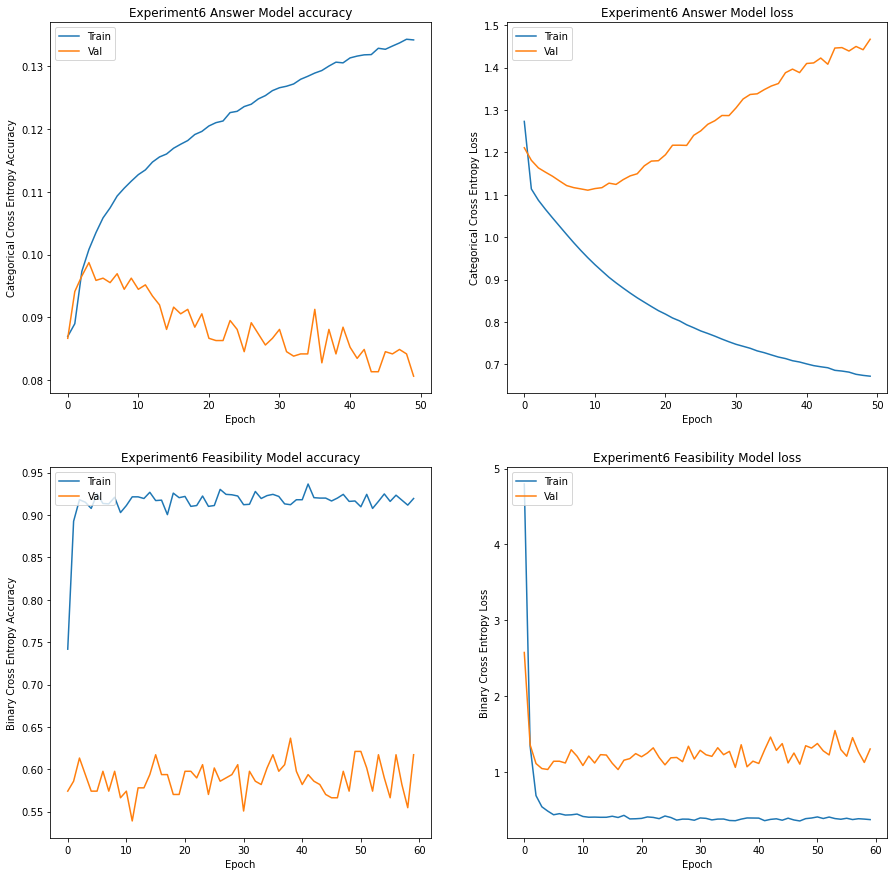

In [3]:
plot_experiments(6)